In [81]:
from dotenv import load_dotenv
from langchain_openai import AzureChatOpenAI, ChatOpenAI
import os
from langchain.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer # type: ignore
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
# from langchain.globals import set_llm_cache
from langchain_community.cache import InMemoryCache
from langchain_core.prompts import PromptTemplate
from langchain.chains import RetrievalQA
load_dotenv()

True

In [106]:
# llm = AzureChatOpenAI(openai_api_version=os.environ.get("AZURE_OPENAI_VERSION", "2023-07-01-preview"),
#     azure_deployment=os.environ.get("AZURE_OPENAI_DEPLOYMENT", "gpt4chat"),
#     azure_endpoint=os.environ.get("AZURE_OPENAI_ENDPOINT", "https://gpt-4-trails.openai.azure.com/"),
#     api_key=os.environ.get("AZURE_OPENAI_KEY"))

In [123]:
llm = ChatOpenAI(
    model = "gpt-3.5-turbo",
    temperature = 0.4,
    max_tokens = 400,
)

In [3]:
file_path = "policy_data.pdf"
loader = PyPDFLoader(file_path)
pages = loader.load()

In [4]:
len(pages)

44

In [6]:
print(pages[30])

page_content='Page 31Where you can drive\nThe area your policy applies \n(the territorial limits)\nYour car insurance gives you the cover \ndescribed in your car insurance details in:\n>Great Britain.\n>Northern Ireland.\n>the Channel Islands.\n>the Isle of Man.\nIt also covers journeys between these places.\nPlease note: your ‘Liability for automated cars in \nGreat Britain’ cover only applies in Great Britain, \nwhich is: \n>England.\n>Scotland.\n>Wales.\nPlease see ‘Liability for automated cars in Great \nBritain’ on page 13 for more details.\nIf you drive in the Republic of Ireland\nIf you use your car in the Republic of Ireland, \nyour car insurance gives you the same cover as \nyou have within the territorial limits. However:\n>If you have Motor Legal Cover, this cover doesn’t apply to any claims in the Republic of Ireland, apart from road traffic accident claims. \n>If you have a courtesy car, it cannot be used \nin the Republic of Ireland.\n>If you have Guaranteed Hire Car Plus

In [7]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=700,
    chunk_overlap=50,
    length_function=len,
)

In [8]:
pages_text = [pages.page_content for pages in pages]
# the type of pages is documents but we need to convert them into list of strings for splitting the text.

In [9]:
documents = splitter.create_documents(pages_text)
# splitting the text into chunks of 250 characters and 50 characters overlap.

In [10]:
type(documents[0])

langchain_core.documents.base.Document

In [11]:
print(documents[1])

page_content='Page 2FAQs  3\nGlossary  4\nMaking a claim  6\nWhat your cover includes  8\nSection 1: Liability  11\nSection 2: Fire and theft  14\nSection 3: Courtesy car  17\nSection 4: Accidental damage  18\nSection 5: Windscreen damage  20\nSection 6: Personal benefits  21\nSection 7: Motor Legal Cover  23\nSection 8: Guaranteed Hire Car Plus  28\nSection 9: Protected No Claim Discount  30Where you can drive  31\nLosses we don’t cover  33\nOther conditions you need to know about  36\nHow the policy works  37\nEverything else  41\nIf you have a complaint  42\nIf you’re in an accident  43\nHow to get in touch  Back coverContentsWelcome to Churchill\nThis booklet tells you about your car insurance\nAbout the policy'


In [12]:
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

In [124]:
# set_llm_cache(InMemoryCache())

In [13]:
def get_vectorstore(text_chunks):
    # Check if the FAISS index file already exists
    if os.path.exists("faiss_index"):
        embeddings = OpenAIEmbeddings()
        # Load the existing FAISS index
        vectorstore = FAISS.load_local("faiss_index", embeddings)
        print("Loaded existing FAISS index.")
    else:
        # Create a new FAISS index
        embeddings = OpenAIEmbeddings()
        vectorstore = FAISS.from_documents(documents=text_chunks, embedding=embeddings)
        # Save the new FAISS index locally
        vectorstore.save_local("faiss_index")
        print("Created and saved new FAISS index.")
    return vectorstore

In [14]:
retriever = get_vectorstore(documents).as_retriever()# here i am using the vector_db as retriever to retrieve the documents.

Created and saved new FAISS index.


In [43]:
template = """Use the context below to answer the question.
Keep the answer concise and to the point.
If you are unsure about the answer, just say i do not know the answer to the question do not create your own answer and make sure the answer is concise and to the point.
Summarize the information such that main points are covered and if you think that there needs to be some more information added to the answer then you can add that information as well.
{context}

Question: {question}

Helpful Answer:"""
prompt = PromptTemplate.from_template(template)

In [44]:
chain_type_kwargs = {"prompt": prompt}
chain = RetrievalQA.from_chain_type(
    llm = llm,
    chain_type="stuff",
    retriever=retriever,
    chain_type_kwargs=chain_type_kwargs,
)

In [45]:
result = chain.invoke("What‚Äôs included in the policy booklet?")

In [46]:
print(result['result'])

The policy booklet includes the car insurance details, certificate(s) of motor insurance, the Green Flag breakdown cover policy booklet (if applicable), and the DriveSure terms and conditions (if applicable). It also includes specific definitions, FAQs, a glossary, instructions for making a claim, details of cover inclusions, sections on various types of coverage, information about where you can drive, losses not covered, other conditions, how the policy works, complaint procedures, accident protocols, and contact information.


In [47]:
### Evaluating using Ragas
import pandas as pd
document = pd.read_csv("insurance_qna.csv")

In [48]:
document.head()

,Query,Response
0,What will you pay if my car is damaged?,We’ll pay the cost of repairing or replacing y...
1,Who is covered to drive other cars?,Your certificate of motor insurance will show ...
2,Am I covered if I leave my car unlocked or the...,"No, we won’t pay a claim for theft or attempte..."
3,What’s not included in my cover?,"Mechanical or electrical failure, wear and tea..."
4,Does Churchill have approved repairers?,"Yes, Churchill customers have access to a nati..."


In [49]:
questions = document["Query"].to_list()
ground_truth = document["Response"].to_list()

In [50]:
from datasets import Dataset
data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

for query in questions:
    data["question"].append(query)
    data["answer"].append(chain.invoke(query))
    data["contexts"].append([doc.page_content for doc in retriever.get_relevant_documents(query, top_k=5)])

dataset = Dataset.from_dict(data)

/Users/siddartha/miniforge3/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [75]:
print(type(dataset))

<class 'datasets.arrow_dataset.Dataset'>


In [66]:
df = pd.DataFrame(dataset)

In [70]:
print(df.columns)

Index(['question', 'answer', 'contexts', 'ground_truth'], dtype='object')


In [71]:
df['answer'] = df['answer'].apply(lambda x: x['result'])

In [72]:
print(df.head())

                                            question  \
0            What will you pay if my car is damaged?   
1                Who is covered to drive other cars?   
2  Am I covered if I leave my car unlocked or the...   
3                   What’s not included in my cover?   
4            Does Churchill have approved repairers?   

                                              answer  \
0  If your car is damaged and the damage is cover...   
1  The main driver may be covered to drive other ...   
2  No, you are not covered if you leave your car ...   
3  Your cover does not include legal claims for l...   
4  Yes, Churchill does have a national network of...   

                                            contexts  \
0  [Page 3FAQs\nHow much will you pay if my car i...   
1  [We’ll also cover any of the following people ...   
2  [the person using it doesn’t take care to keep...   
3  [Page 25Section 7: Motor Legal Cover\nYou’re n...   
4  [>For a purpose that’s not allowed on the p

In [76]:
dataset = Dataset.from_pandas(df)

In [124]:
import ragas
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_precision,
    context_recall,
    context_relevancy,
)
run_config = ragas.RunConfig(timeout=60, max_retries=11, max_wait=100)

result = evaluate(
    dataset = dataset,
    llm = llm,
    run_config=run_config,
    metrics=[
        faithfulness,
        answer_relevancy,
    ],
)

Evaluating:   0%|          | 0/78 [00:00<?, ?it/s]

Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.


/Users/siddartha/miniforge3/lib/python3.10/site-packages/datasets/table.py:1381: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/Users/siddartha/miniforge3/lib/python3.10/site-packages/datasets/table.py:1407: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


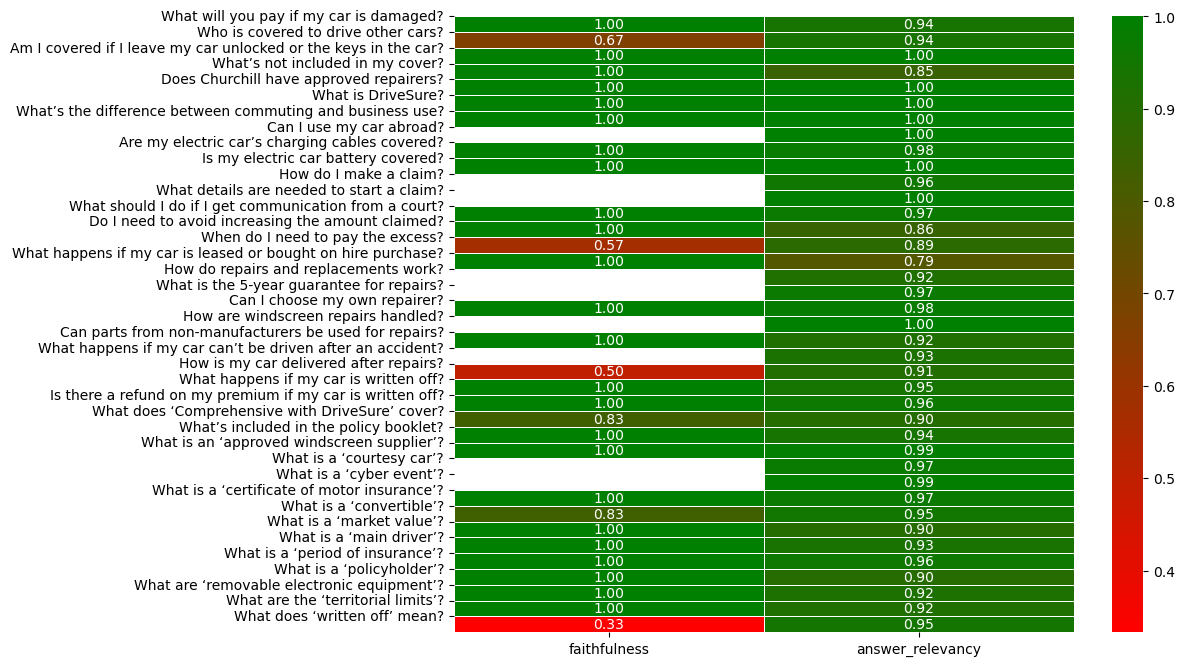

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = result.to_pandas()

heatmap_data = df[['faithfulness', 'answer_relevancy']]

cmap = LinearSegmentedColormap.from_list('green_red', ['red', 'green'])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap=cmap)

plt.yticks(ticks=range(len(df['question'])), labels=df['question'], rotation=0)

plt.show()

In [ ]:
"""
You are a language model designed to evaluate the responses of this documentation query system.
You will use a rating scale of 0 to 10, 0 being poorest response and 10 being the best.
Responses with “not specified” or “no specific mention” or “rephrase question” or “unclear” or no documents returned or empty response are considered poor responses.
Responses where the question appears to be answered are considered good.
Responses that contain detailed answers are considered the best.
Also, use your own judgement in analyzing if the question asked is actually answered in the response. Remember that a response that contains a request to “rephrase the question” is usually a non-response.
Please rate the question/response pair entered. Only respond with the rating. No explanation necessary. Only integers.
"""

In [126]:
print(chain.invoke("waht is a cyber event?")["result"])

A cyber event is an unauthorized, malicious or criminal act that aims to create an outcome that includes, but is not limited to, interruption to electronic communications, corruption, unauthorized access to, or theft of data, and hacking or service denial.
